# Sprint 1 — Jesse Traas (Group 23)

*Jesse's personal file for EDA and sprint tasks.*

## Table of contents
1. [EDA](#1-eda)  
  1.1 [General info](#11-general-info)  
  1.2 [Events](#12-events)  
  1.3 [Frequency of events](#13-frequency-of-events)  
2. [Common trace](#2-activity-type-prediction)  
  2.1 [Max trace](#21-max-trace)  
  2.2 [Common trace](#22-most-common-trace)  
3. [Case end time prediction](#3-case-end-time-prediction)  
  3.1 [Error checking](#31-error-checking)  
  3.2 [Output](#32-output)  
4. [Case end time prediction analysis](#4-case-end-time-prediction-analysis)

# 1. EDA

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Read TRAIN data
df_train = pd.read_csv('../bpi_2012_train.csv', low_memory=False)
df_train = df_train.loc[0:1000]

# Make datetimes datetimes for train
dt_format = '%Y/%m/%d %H:%M:%S.%f'
df_formatted = pd.to_datetime(df_train[['event time:timestamp', 'case REG_DATE']].stack(), format=dt_format, utc=True).unstack()

df_train['event time:timestamp'] = df_formatted['event time:timestamp']
df_train['case REG_DATE'] = df_formatted['case REG_DATE']


# Read TEST data
df_test = pd.read_csv('../bpi_2012_test.csv', low_memory=False)
df_test = df_test.loc[0:1000]

# Make datetimes datetimes for train
dt_format = '%Y/%m/%d %H:%M:%S.%f'
df_test_formatted = pd.to_datetime(df_test[['event time:timestamp', 'case REG_DATE']].stack(), format=dt_format, utc=True).unstack()

df_test['event time:timestamp'] = df_test_formatted['event time:timestamp']
df_test['case REG_DATE'] = df_test_formatted['case REG_DATE']

## 1.1 General info

In [148]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Unnamed: 0                  1001 non-null   int64              
 1   eventID                     1001 non-null   int64              
 2   case concept:name           1001 non-null   int64              
 3   case REG_DATE               1001 non-null   datetime64[ns, UTC]
 4   case AMOUNT_REQ             1001 non-null   int64              
 5   event concept:name          1001 non-null   object             
 6   event lifecycle:transition  1001 non-null   object             
 7   event time:timestamp        1001 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(4), object(2)
memory usage: 62.7+ KB


,Unnamed: 0,eventID,case concept:name,case AMOUNT_REQ
count,1001.00000,1.001000e+03,1001.000000,1001.000000
mean,24311.74026,4.937264e+12,177303.422577,12661.625375
std,18760.97089,4.278999e+12,3134.717147,9284.401312
min,0.00000,0.000000e+00,173688.000000,1000.000000
25%,250.00000,8.589935e+10,173748.000000,5000.000000
50%,38698.00000,5.815386e+12,177941.000000,10000.000000
75%,38948.00000,9.771051e+12,180847.000000,15000.000000
max,39198.00000,1.036805e+13,181273.000000,59400.000000


## 1.2 Events

In [149]:
df_train_events = df_train[['event concept:name']]
df_train_events.describe()

,event concept:name
count,1001
unique,23
top,W_Completeren aanvraag
freq,215


## 1.3 Frequency of events

<AxesSubplot:title={'center':'Frequency of event types\n'}, ylabel='event concept:name'>

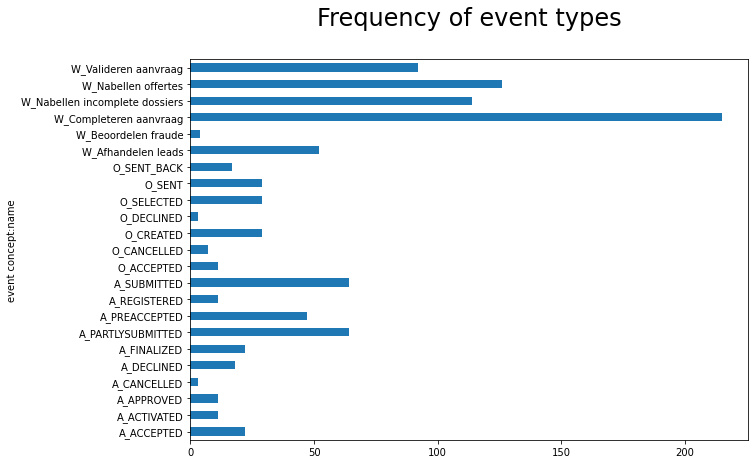

In [150]:
counts = df_train_events.sort_values(by='event concept:name', ascending=False).groupby(by='event concept:name')['event concept:name'].count()
plt.title('Frequency of event types\n', fontdict={'fontsize': 24})
counts.plot.barh(figsize=(10, 7))

# 2. Activity type prediction
The section below focusses on predicting the type of next activity. I thought it would be required for the prediction of the time until the end of the trace, but with the power of hindsight I can say this was not necessary. I kept it in this document for completeness' sake.

## 2.1 Max trace

In [151]:
df_train_grouped = df_train.groupby('case concept:name')
df_train_grouped_sorted = df_train.sort_values('event time:timestamp').groupby('case concept:name')
df_max_trace = df_train[df_train['case concept:name'] == df_train_grouped.size().idxmax()]
df_max_trace.describe()
df_train_grouped.tail(1).groupby('event concept:name').describe()

Unnamed: 0                              \
                                    count          mean           std   
event concept:name                                                      
A_CANCELLED                           1.0  38629.000000           NaN   
A_DECLINED                            9.0   8766.000000  17020.658815   
A_PARTLYSUBMITTED                     1.0    376.000000           NaN   
W_Afhandelen leads                   11.0  24926.000000  19525.771790   
W_Beoordelen fraude                   1.0  38742.000000           NaN   
W_Completeren aanvraag               52.0  23299.365385  19138.654287   
W_Nabellen incomplete dossiers       29.0  38875.551724    188.691280   
W_Nabellen offertes                  40.0  32203.075000  14935.877294   
W_Valideren aanvraag                 17.0  38942.470588    211.166142   

                                                                              \
                                    min      25%      50%       75%      max   
event concept:name                                                             
A_CANCELLED                     38629.0  38629.0  38629.0  38629.00  38629.0   
A_DECLINED                         14.0    115.0    295.0    374.00  38940.0   
A_PARTLYSUBMITTED                 376.0    376.0    376.0    376.00    376.0   
W_Afhandelen leads                187.0    351.5  38802.0  39118.50  39184.0   
W_Beoordelen fraude             38742.0  38742.0  38742.0  38742.00  38742.0   
W_Completeren aanvraag             88.0    332.0  38815.5  38875.50  39192.0   
W_Nabellen incomplete dossiers  38602.0  38712.0  38852.0  39026.00  39172.0   
W_Nabellen offertes                70.0  38780.5  38988.5  39075.75  39176.0   
W_Valideren aanvraag            38612.0  38729.0  39014.0  39094.00  39198.0   

                               eventID                               \
                                  count          mean           std   
event concept:name                                                    
A_CANCELLED                         1.0  3.006477e+10           NaN   
A_DECLINED                          9.0  2.358891e+12  4.513059e+12   
A_PARTLYSUBMITTED                   1.0  1.760937e+11           NaN   
W_Afhandelen leads                 11.0  6.615031e+12  5.152753e+12   
W_Beoordelen fraude                 1.0  8.826158e+12           NaN   
W_Completeren aanvraag             52.0  5.997261e+12  4.916221e+12   
W_Nabellen incomplete dossiers     29.0  4.677516e+12  2.174908e+12   
W_Nabellen offertes                40.0  6.014780e+12  3.609614e+12   
W_Valideren aanvraag               17.0  6.673621e+12  1.336183e+12   

                                                                          \
                                         min           25%           50%   
event concept:name                                                         
A_CANCELLED                     3.006477e+10  3.006477e+10  3.006477e+10   
A_DECLINED                      1.288490e+10  5.583457e+10  1.159641e+11   
A_PARTLYSUBMITTED               1.760937e+11  1.760937e+11  1.760937e+11   
W_Afhandelen leads              6.442451e+10  1.460289e+11  1.029074e+13   
W_Beoordelen fraude             8.826158e+12  8.826158e+12  8.826158e+12   
W_Completeren aanvraag          8.589935e+09  1.213328e+11  9.637907e+12   
W_Nabellen incomplete dossiers  1.374390e+11  4.105989e+12  4.651450e+12   
W_Nabellen offertes             1.300000e+01  3.416646e+12  7.286412e+12   
W_Valideren aanvraag            3.564823e+12  5.467493e+12  7.413114e+12   

                                                           case concept:name  \
                                         75%           max             count   
event concept:name                                                             
A_CANCELLED                     3.006477e+10  3.006477e+10               1.0   
A_DECLINED                      1.717987e+11  1.033799e+13               9.0   
A_PARTLYSUBMITTED          

## 2.2 Most common trace
The block below constructs a sequence of size N (where N is the length of the longest trace) of the most common event types at the i-th position of any trace.

In [152]:
mct = []
for i in range(0, len(df_max_trace.index)):
    frequencies = df_train_grouped.nth(i)[['event concept:name']].value_counts()
    most_frequent = frequencies[0:1].index.tolist()[0][0]
    mct.append(most_frequent)

mct

['A_SUBMITTED',
 'A_PARTLYSUBMITTED',
 'A_PREACCEPTED',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'O_SENT',
 'W_Nabellen offertes',
 'W_Completeren aanvraag',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'A_FINALIZED',
 'O_SELECTED',
 'W_Nabellen offertes',
 'O_SENT',
 'W_Nabellen offertes',
 'W_Completeren aanvraag',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'O_SELECTED',
 'O_CANCELLED',
 'O_CREATED',
 'O_SENT',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'W_Nabellen offertes',
 'W_Nabellen offertes']

# 3. Case end time prediction
This section is for attempting to estimate how long a trace will take from a particular event type onwards to complete. It only uses the event type in the estimation.

The estimation is made as follows.

1. Group all events in the dataset by event type. For example, you'll have one group for "W_Nabellen offertes", "O_CREATED", etc.
2. For every event in the groups, check the time difference between this event and the end time of its trace.
3. Take the average of all of these time differences per group to find out how long it usually takes from that event type until the end of the case. This is considered the prediction.

> *Example*: After "W_Nabellen offertes" it takes on average 45000 seconds for the case to end, so if an event is of type "W_Nabellen offertes", this model predicts 45000 seconds until the trace ends.

In [153]:
# For every event in the list, find the final event in the its case and store it's time as the trace end time
df_train_trace_end = df_train_grouped_sorted.tail(1)[['case concept:name', 'event time:timestamp']]
df_train_trace_end = df_train_trace_end.rename(columns={"case concept:name": "case concept:name", "event time:timestamp": "trace_end"})

In [154]:
df_train_grouped_event = df_train.groupby('event concept:name')[['case concept:name', 'event concept:name', 'event time:timestamp']]
df_train_event_diffs = pd.DataFrame(columns=['type', 'prediction_time_trace_end'])

for name, group in df_train_grouped_event:
    # Loop over all events of type `name` and get the complete time of their trace

    # Merge the current group with the trace_end data
    merged = group.merge(df_train_trace_end, on="case concept:name", how="outer")
    
    # Create a new series indicating the difference between the end of the trace and the completion of the current event
    diff_series = merged['trace_end'] - merged['event time:timestamp']

    # Add the time difference to the dataframe in seconds
    merged['differential (s)'] = diff_series
    merged['differential (s)'] = merged['differential (s)'].apply(lambda x: x.total_seconds())

    # Add the average differential to the dataframe
    df_group_diff = pd.DataFrame([[name, round(merged['differential (s)'].mean())]], columns=['type', 'prediction_time_trace_end'])
    df_train_event_diffs = pd.concat([df_train_event_diffs, df_group_diff], ignore_index=True)

df_train_event_diffs

,type,prediction_time_trace_end
0,A_ACCEPTED,475
1,A_ACTIVATED,8
2,A_APPROVED,8
3,A_CANCELLED,1
4,A_DECLINED,2
5,A_FINALIZED,232
6,A_PARTLYSUBMITTED,7862
7,A_PREACCEPTED,7966
8,A_REGISTERED,8
9,A_SUBMITTED,7862


## 3.1 Error checking
In the attempt above to predict the finish time of the request, some errors came up. The cells below are meant to check these.

### Problem: Some events happen after their trace ended
Some events have a negative time differential from the event itself to the trace end. This implies that the trace end value isn't correct. The cells below have been used to check this, and it seems like the cases are not by default sorted by completion time. This is required to get a correct `traceEnd` value, so sorting has been implemented in the cells above.

In [155]:
#df_grouped.get_group('Application_1691306052').sort_values('completeTime')

## 3.2 Output
This cell should produce the final output dataframe, to be exported to CSV!

In [156]:
result_train = df_train.merge(df_train_event_diffs, left_on='event concept:name', right_on='type', how='left').drop(columns = ['type'])
result_train.head(10)

result_test = df_test.merge(df_train_event_diffs, left_on='event concept:name', right_on='type', how='left').drop(columns = ['type'])
result_test.head(10)

,Unnamed: 0,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,prediction_time_trace_end
0,38021,56182467198976,214361,2012-02-29 22:11:37.974000+00:00,5000,A_SUBMITTED,COMPLETE,2012-01-03 00:11:37.975000+00:00,7862
1,38022,56182467198977,214361,2012-02-29 22:11:37.974000+00:00,5000,A_PARTLYSUBMITTED,COMPLETE,2012-01-03 00:11:38.115000+00:00,7862
2,38023,56182467198978,214361,2012-02-29 22:11:37.974000+00:00,5000,A_PREACCEPTED,COMPLETE,2012-01-03 00:12:15.783000+00:00,7966
3,38024,56182467198979,214361,2012-02-29 22:11:37.974000+00:00,5000,W_Completeren aanvraag,SCHEDULE,2012-01-03 00:12:16.190000+00:00,4291
4,38025,56186762166272,214364,2012-02-29 22:22:24.570000+00:00,5000,A_SUBMITTED,COMPLETE,2012-01-03 00:22:24.570000+00:00,7862
5,38026,56186762166273,214364,2012-02-29 22:22:24.570000+00:00,5000,A_PARTLYSUBMITTED,COMPLETE,2012-01-03 00:22:24.657000+00:00,7862
6,38027,56186762166274,214364,2012-02-29 22:22:24.570000+00:00,5000,A_PREACCEPTED,COMPLETE,2012-01-03 00:23:01.532000+00:00,7966
7,38028,56186762166275,214364,2012-02-29 22:22:24.570000+00:00,5000,W_Completeren aanvraag,SCHEDULE,2012-01-03 00:23:01.893000+00:00,4291
8,38029,56191057133568,214367,2012-02-29 22:28:41.098000+00:00,500,A_SUBMITTED,COMPLETE,2012-01-03 00:28:41.098000+00:00,7862
9,38030,56191057133569,214367,2012-02-29 22:28:41.098000+00:00,500,A_PARTLYSUBMITTED,COMPLETE,2012-01-03 00:28:41.198000+00:00,7862


# 4. End of case prediction analysis
## 4.1 Analysis with training data
This section is meant to check how good this estimation actually is. The first block analyzes the performance of the model on the training data (to check the variance).

Error percentage of full dataset


,error_percentage
count,1001.000000
mean,55874.518482
std,147504.679383
min,-94.000000
25%,-8.000000
50%,206.000000
75%,13600.000000
max,796500.000000


Error percentage capped at 5000, for plotting purposes


,error_percentage
count,691.000000
mean,273.868307
std,689.843539
min,-94.000000
25%,-35.500000
50%,33.000000
75%,260.000000
max,4889.000000


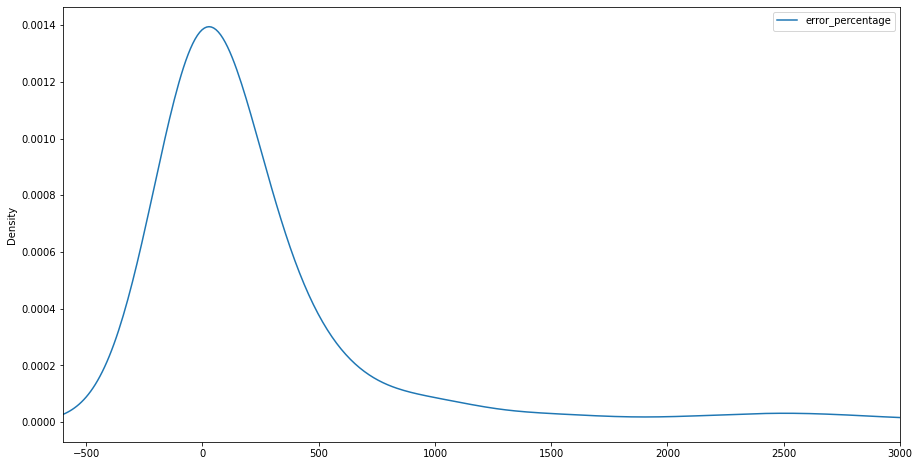

In [157]:
r_train_analysis = result_train.merge(df_train_trace_end, on='case concept:name', how='left')
diff_series = r_train_analysis['trace_end'] - r_train_analysis['event time:timestamp']

# Add the time difference to the dataframe in seconds
r_train_analysis['time_trace_end'] = diff_series.apply(lambda x: round(x.total_seconds()) if round(x.total_seconds()) != 0 else 1 )

r_train_analysis['error_percentage'] = round(((r_train_analysis['prediction_time_trace_end'] - r_train_analysis['time_trace_end']) / r_train_analysis['time_trace_end'] * 100).astype(int))
r_train_analysis.head(10)

# Select a subset with error percentage below 5000, for plotting purposes
r_train_analysis_plot = r_train_analysis[r_train_analysis['error_percentage'] < 5000]
ax = r_train_analysis_plot.plot.kde(y='error_percentage', use_index=True, figsize=(15, 8), bw_method=0.3)
ax.set_xlim(-600, 3000)
ax

print("Error percentage of full dataset")
display(r_train_analysis[['error_percentage']].describe())
print("Error percentage capped at 5000, for plotting purposes")
r_train_analysis_plot[['error_percentage']].describe()

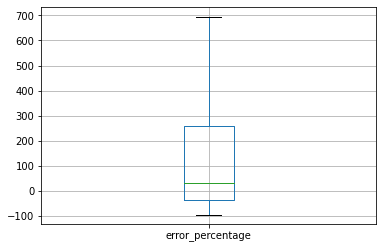

In [158]:
ax_bp = r_train_analysis_plot.boxplot(column='error_percentage', showfliers=False)

## 4.2 Analysis with testing data

In [159]:
# Generate case end time for training data
df_test_grouped_sorted = df_test.sort_values('event time:timestamp').groupby('case concept:name')
df_test_trace_end = df_test_grouped_sorted.tail(1)[['case concept:name', 'event time:timestamp']]
df_test_trace_end = df_test_trace_end.rename(columns={"case concept:name": "case concept:name", "event time:timestamp": "trace_end"})

Error percentage of full dataset


,error_percentage
count,1001.000000
mean,54902.381618
std,128322.604345
min,-99.000000
25%,-33.000000
50%,196.000000
75%,13600.000000
max,796500.000000


Error percentage capped at 5000, for plotting purposes


,error_percentage
count,663.000000
mean,270.773756
std,730.136235
min,-99.000000
25%,-71.000000
50%,0.000000
75%,186.500000
max,4667.000000


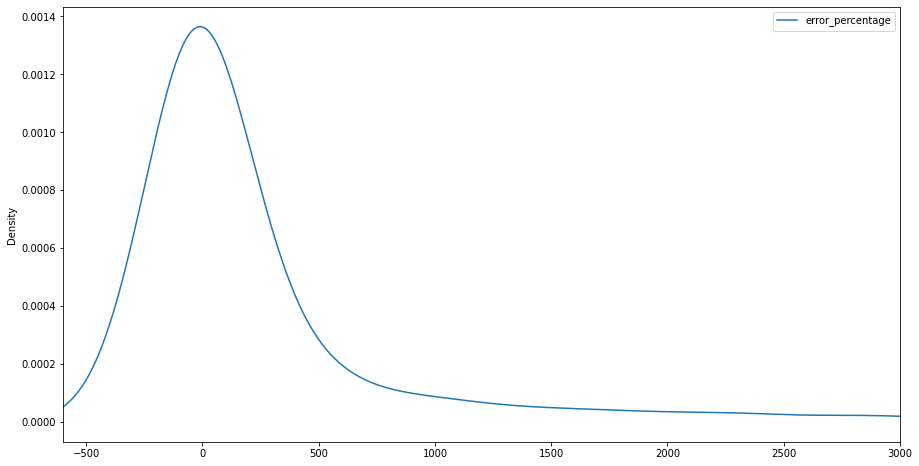

In [160]:
r_test_analysis = result_test.merge(df_test_trace_end, on='case concept:name', how='left')
diff_series = r_test_analysis['trace_end'] - r_test_analysis['event time:timestamp']

# Add the time difference to the dataframe in seconds
r_test_analysis['time_trace_end'] = diff_series.apply(lambda x: round(x.total_seconds()) if round(x.total_seconds()) != 0 else 1 )

r_test_analysis['error_percentage'] = round(((r_test_analysis['prediction_time_trace_end'] - r_test_analysis['time_trace_end']) / r_test_analysis['time_trace_end'] * 100).astype(int))
r_test_analysis.head(10)

# Select a subset with error percentage below 5000, for plotting purposes
r_test_analysis_plot = r_test_analysis[r_test_analysis['error_percentage'] < 5000]
ax = r_test_analysis_plot.plot.kde(y='error_percentage', use_index=True, figsize=(15, 8), bw_method=0.3)
ax.set_xlim(-600, 3000)
ax

print("Error percentage of full dataset")
display(r_test_analysis[['error_percentage']].describe())
print("Error percentage capped at 5000, for plotting purposes")
r_test_analysis_plot[['error_percentage']].describe()

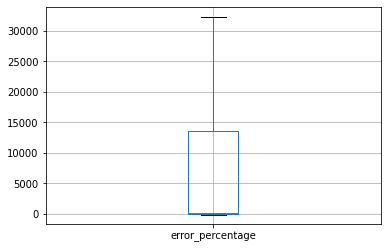

In [161]:
ax_bp = r_test_analysis.boxplot(column='error_percentage', showfliers=False)

## 4.3 Analysis conclusion
This "naïve" or "baseline" prediction is not too great. The error percentage without outliers, of which the distribution is shown in the boxplot above, indicates that the baseline is commonly off, and tends to overestimate the completion time of the case. The biggest problem is that there are some insane outliers, the worst having an error percentage of *800.000%*.